In [46]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from pyproj import Geod
import ctd 
import cmocean.cm as cmo
import gsw
import cartopy.crs as ccrs
import cartopy.feature as cfeature # type: ignore


In [47]:
# The weather the week prior to the cruise
# https://seklima.met.no/hours/max(rainfall_rate%20PT1M),air_pressure_at_sea_level,air_temperature,wind_speed,cloud_area_fraction/custom_period/SN18700/nb/2024-04-11T00:00:00+02:00;2024-04-18T23:59:59+02:00


In [48]:
# List of files
#f = ['GF1.cnv', 'GF2.cnv', 'GF3.cnv', 'Lysakerfj_BN1_B.cnv', 'GF4.cnv', 'GF5.cnv', 'GF6.cnv', 'GF7.cnv'] # Hele

# f = ['Lysakerfj_BN1_B.cnv', 'GF3.cnv', 'GF2.cnv', 'GF1.cnv'] # Syd
# snitt = 'syd'

f = ['Lysakerfj_BN1_B.cnv', 'GF4.cnv', 'GF5.cnv', 'GF6.cnv', 'GF7.cnv'] # Nord
snitt = 'nord'

N = len(f)

In [49]:
# Read profiles
stations = []

for i in range(N):
    stations.append(ctd.from_cnv('data/2024/seabird/' + f[i]))


In [50]:
# Get positions and time
lat = [stations[i]._metadata['lat'] for i in range(N)]
lon = [stations[i]._metadata['lon'] for i in range(N)]
t = [stations[i]._metadata['time'] for i in range(N)]


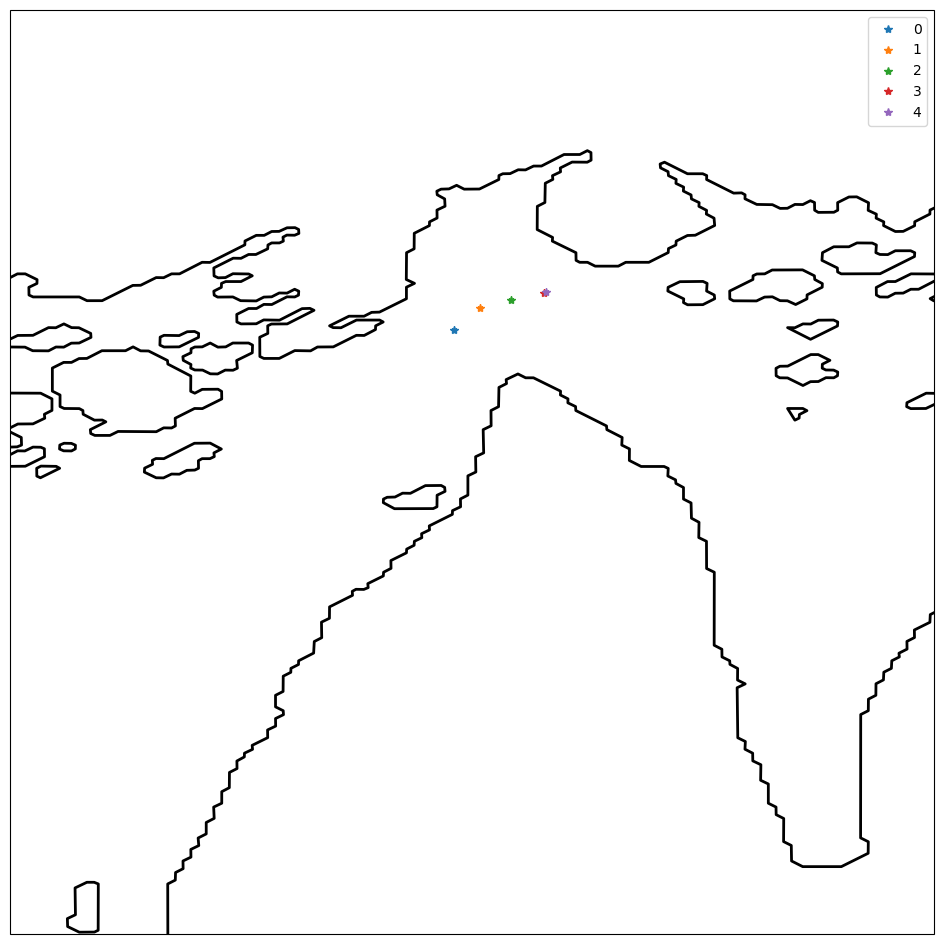

In [51]:
# Plot the stations on a map
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
coast = cfeature.GSHHSFeature(scale="full")

ax.add_feature(coast, linewidth=2)
ax.set_extent([10.55, 10.75, 59.75, 59.95])

for i in range(N):
    plt.plot(lon[i], lat[i], '*', label=str(i))

plt.legend()

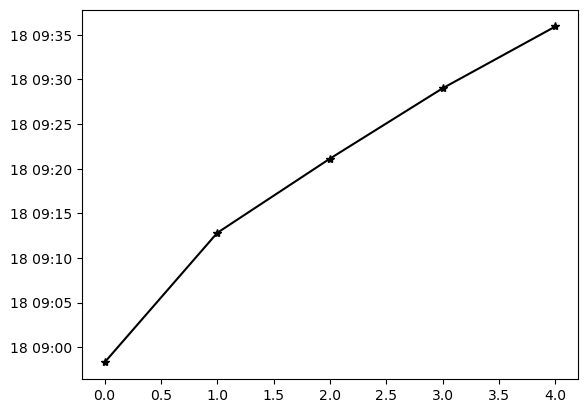

In [52]:
# Plot sampling time to check on order
plt.plot(t, 'k-*')

In [53]:
# Generate array containing relative distances between stations
g = Geod(ellps='WGS84')
dx = [0.0]

for i in range(N-1):
    _, _, d = g.inv(lon[i+1], lat[i+1], lon[i], lat[i])
    dx.append(d)

# Generate array with cumulative distances
x = np.cumsum(dx)

In [54]:
# Get temp, salt, sigma_t values and prep for "tricontourf"
temp = []
salt = []
sigma_t = []
D = []
L = []

for i in range(N):
    temp = np.append(temp, stations[i].t090C.values, axis=0)
    salt = np.append(salt, stations[i].sal00.values, axis=0)
    sigma_t = np.append(sigma_t, stations[i]['sigma-t00'].values, axis=0)
    D = np.append(D, stations[i].depSM.values, axis=0)
    L = np.append(L, x[i]*np.ones_like(stations[i].depSM.values), axis=0)
    

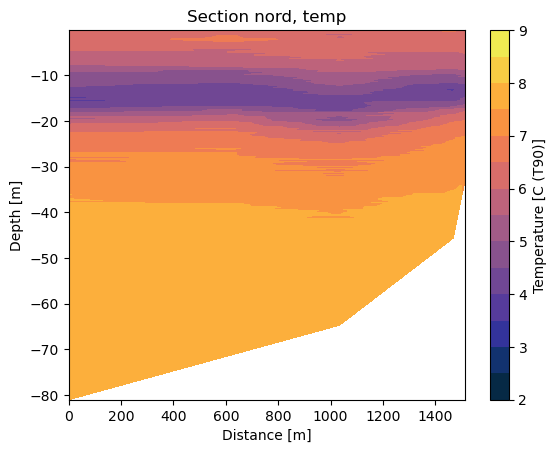

In [55]:
# Plot temperature in section
plt.tricontourf(L, -D, temp, levels=np.linspace(2,9,15), cmap=cmo.thermal)
plt.title('Section ' + snitt + ', temp')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
plt.colorbar(label='Temperature [C (T90)]')

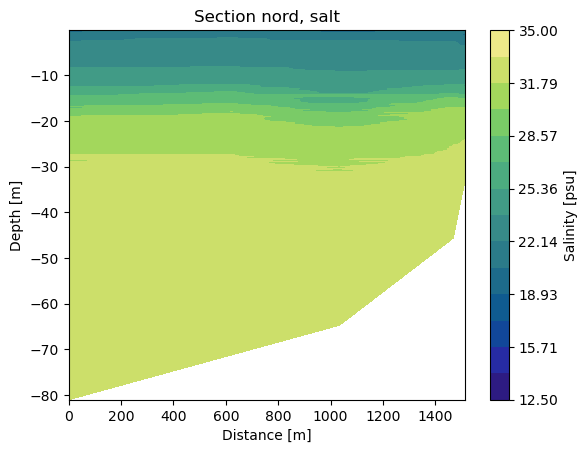

In [56]:
# Plot salinity in section
plt.tricontourf(L, -D, salt, levels=np.linspace(12.5,35,15), cmap=cmo.haline)
plt.title('Section ' + snitt + ', salt')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
plt.colorbar(label='Salinity [psu]')

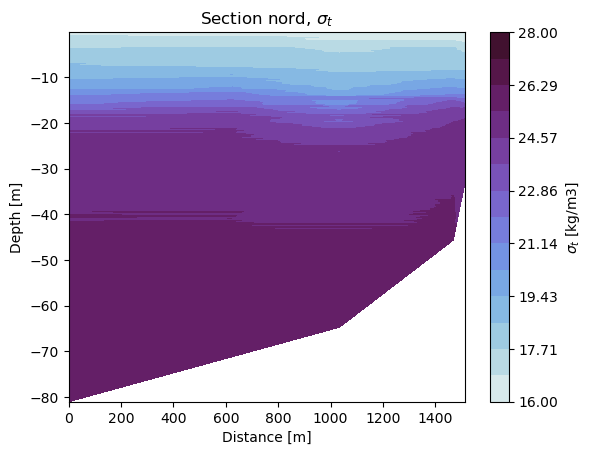

In [57]:
# Plot density (sigma_t) in section
plt.tricontourf(L, -D, sigma_t, levels=np.linspace(16,28,15), cmap=cmo.dense)
plt.title('Section ' + snitt + ', $\sigma_t$')
plt.xlabel('Distance [m]')
plt.ylabel('Depth [m]')
plt.colorbar(label='$\sigma_t$ [kg/m3]')

Text(0.5, 1.0, 'Section nord')

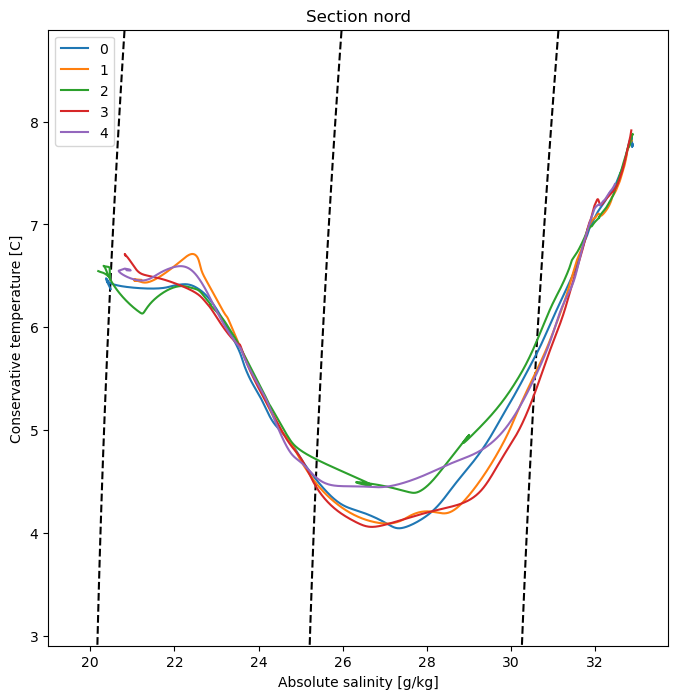

In [58]:
# Make TS diagrams (values converted to TEOS-10 CT/SA)
temprange = np.linspace(-2,30,100)
saltrange = np.linspace(5,37,100)
T, S = np.meshgrid(temprange, saltrange)
dens = gsw.density.rho(S,T,0.0)

# Make figure
ca = plt.figure(figsize=(8,8))
plt.contour(S, T, dens, linestyles='dashed', colors='black')

# Loop over stations, rough smoothing!
for i in range(N):

    # Get data from station
    winlen = 100
    ptemp = stations[i].smooth(window_len=winlen).t090C.values
    psalt = stations[i].smooth(window_len=winlen).sal00.values
    pdepth = stations[i].smooth(window_len=winlen).depSM.values
    
    # Convert to CT and SA
    p = gsw.conversions.p_from_z(-pdepth, 57.0)
    SA = gsw.conversions.SA_from_SP(psalt, p, 10.0, 57.0)
    CT = gsw.conversions.CT_from_t(SA, ptemp, p)

    plt.plot(SA, CT, '-', label=str(i))
    
plt.legend()
# plt.xlim((5, 37))
# plt.ylim((-2, 30))
plt.xlim((np.min(salt)-1, np.max(salt)+1))
plt.ylim((np.min(temp)-1, np.max(temp)+1))
plt.xlabel('Absolute salinity [g/kg]')
plt.ylabel('Conservative temperature [C]')
plt.title('Section ' + snitt)

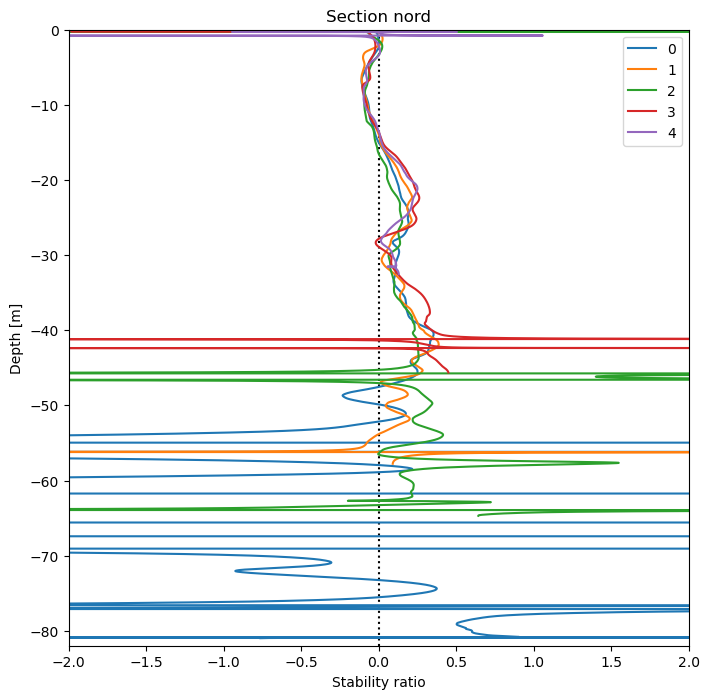

In [59]:
# Plot stability/density ratio
 
# Make figure
ca = plt.figure(figsize=(8,8))

plt.xlim((-2, 2))
plt.ylim((np.min(-D)-1, 0))
plt.xlabel('Stability ratio')
plt.ylabel('Depth [m]')
plt.title('Section ' + snitt)

# Plot zero line
plt.plot([0,0], [np.min(-D)-1, 0], 'k:')

# Loop over stations, rough smoothing!
for i in range(N):

    # Get data from station
    winlen = 200
    ptemp = stations[i].smooth(window_len=winlen).t090C.values
    psalt = stations[i].smooth(window_len=winlen).sal00.values
    pdepth = stations[i].smooth(window_len=winlen).depSM.values
    
    # Convert to CT and SA
    p = gsw.conversions.p_from_z(-pdepth, 57.0)
    SA = gsw.conversions.SA_from_SP(psalt, p, 10.0, 57.0)
    CT = gsw.conversions.CT_from_t(SA, ptemp, p)

    # Calculate stablility ratio
    Tu, Rs, pmid = gsw.Turner_Rsubrho(SA,CT,p)

    plt.plot(Rs, gsw.z_from_p(pmid,57.0), '-', label=str(i))

plt.legend()

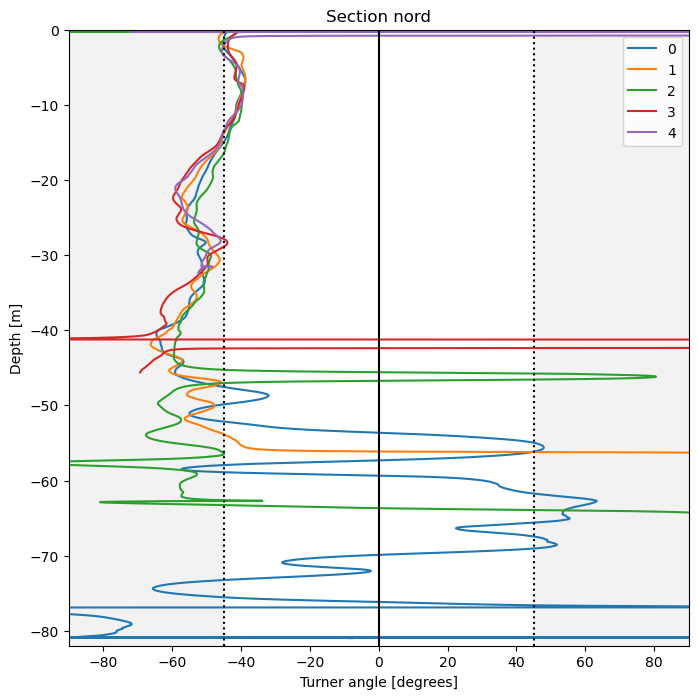

In [60]:
# Make figure
ca = plt.figure(figsize=(8,8))

# Plot Turner angles
plt.xlim((-90, 90))
plt.ylim((np.min(-D)-1, 0))
plt.xlabel('Turner angle [degrees]')
plt.ylabel('Depth [m]')
plt.title('Section ' + snitt)

plt.axvspan(-180, -45, facecolor='0.95')
plt.axvspan(45, 180, facecolor='0.95')

# Loop over stations, rough smoothing!
for i in range(N):

    # Get data from station
    winlen = 200
    ptemp = stations[i].smooth(window_len=winlen).t090C.values
    psalt = stations[i].smooth(window_len=winlen).sal00.values
    pdepth = stations[i].smooth(window_len=winlen).depSM.values
    
    # Convert to CT and SA
    p = gsw.conversions.p_from_z(-pdepth, 59.0)
    SA = gsw.conversions.SA_from_SP(psalt, p, 10.0, 59.0)
    CT = gsw.conversions.CT_from_t(SA, ptemp, p)
    
    # Calculate stablility ratio
    Tu, Rs, pmid = gsw.Turner_Rsubrho(SA,CT,p)

    plt.plot(Tu, gsw.z_from_p(pmid,59.0), '-', label=str(i))

plt.plot([0,0],[np.min(-D)-1, 0],'k-')
plt.plot([-45,-45],[np.min(-D)-1, 0],'k:')
plt.plot([45,45],[np.min(-D)-1, 0],'k:')

plt.legend()